In [18]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import tqdm
import pickle

import robustness_model

In [2]:
train_data = datasets.MNIST(root = './datasets/',
                            train=True,
                            download=True,
                            transform=transforms.ToTensor())
test_data = datasets.MNIST(root = './datasets/',
                            train=False,
                            download=True,
                            transform=transforms.ToTensor())
print('number of training data : ', len(train_data))
print('number of test data : ', len(test_data))

number of training data :  60000
number of test data :  10000


In [3]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./datasets/
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
train_data.data.shape, train_data.targets.shape

(torch.Size([60000, 28, 28]), torch.Size([60000]))

In [5]:
X_train = train_data.data
y_train = train_data.targets
X_test = test_data.data
y_test = test_data.targets

In [6]:
X_train = X_train[(y_train == 0) | (y_train == 1)].reshape(-1, 28*28) / 255
y_train = y_train[(y_train == 0) | (y_train == 1)]
X_test = X_test[(y_test == 0) | (y_test == 1)].reshape(-1, 28*28) / 255
y_test = y_test[(y_test == 0) | (y_test == 1)]

In [7]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([12665, 784]),
 torch.Size([12665]),
 torch.Size([2115, 784]),
 torch.Size([2115]))

In [8]:
original_dim = 28*28
dim = 10000

In [9]:
encoder = robustness_model.FHRREncoder(original_dim, dim)
model = robustness_model.ClassificationModel(encoder, in_dim=original_dim, dim=dim)
model.bundling(X_train, y_train)

preds = model.predict(X_train)
(preds == y_train).sum() / len(y_train)

tensor(0.8425)

In [10]:
def overall_robustness(model: robustness_model.ClassificationModel, X):
    
    ep1s = []
    ep2s = []
    ep3s = []

    L3 = model.get_lipschitz_constant()
    
    for x in tqdm.tqdm(X):
        
        L1 = model.get_linear_approximation(x)
        L2 = model.get_conservative_lipschitz_constant(x)

        ep1 = model.get_eps(x, L1)
        ep2 = model.get_eps(x, L2)
        ep3 = model.get_eps(x, L3)

        ep1s.append(ep1)
        ep2s.append(ep2)
        ep3s.append(ep3)
    
    return torch.tensor(ep1s), torch.tensor(ep2s), torch.tensor(ep3s)

In [11]:
ep1s_train, ep2s_train, ep3s_train = overall_robustness(model, X_train)
ep1s_train.mean(), ep2s_train.mean(), ep3s_train.mean()

100%|██████████| 12665/12665 [17:23:35<00:00,  4.94s/it]  


(tensor(0.1048), tensor(0.4752), tensor(0.0999))

In [12]:
ep1s_test, ep2s_test, ep3s_test = overall_robustness(model, X_test)
ep1s_test.mean(), ep2s_test.mean(), ep3s_test.mean()

100%|██████████| 2115/2115 [3:25:48<00:00,  5.84s/it]  


(tensor(0.0965), tensor(0.4402), tensor(0.0930))

In [19]:
with open('./epsilons.pickle', 'bw') as f:
    pickle.dump((ep1s_train, ep2s_train, ep3s_train, ep1s_test, ep2s_test, ep3s_test), f)

In [20]:
with open('./model.pickle', 'bw') as f:
    pickle.dump(model, f)

/var/folders/0d/85ds7j1x59j1dwn1s6nph45m0000gn/T/ipykernel_24632/1741667558.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


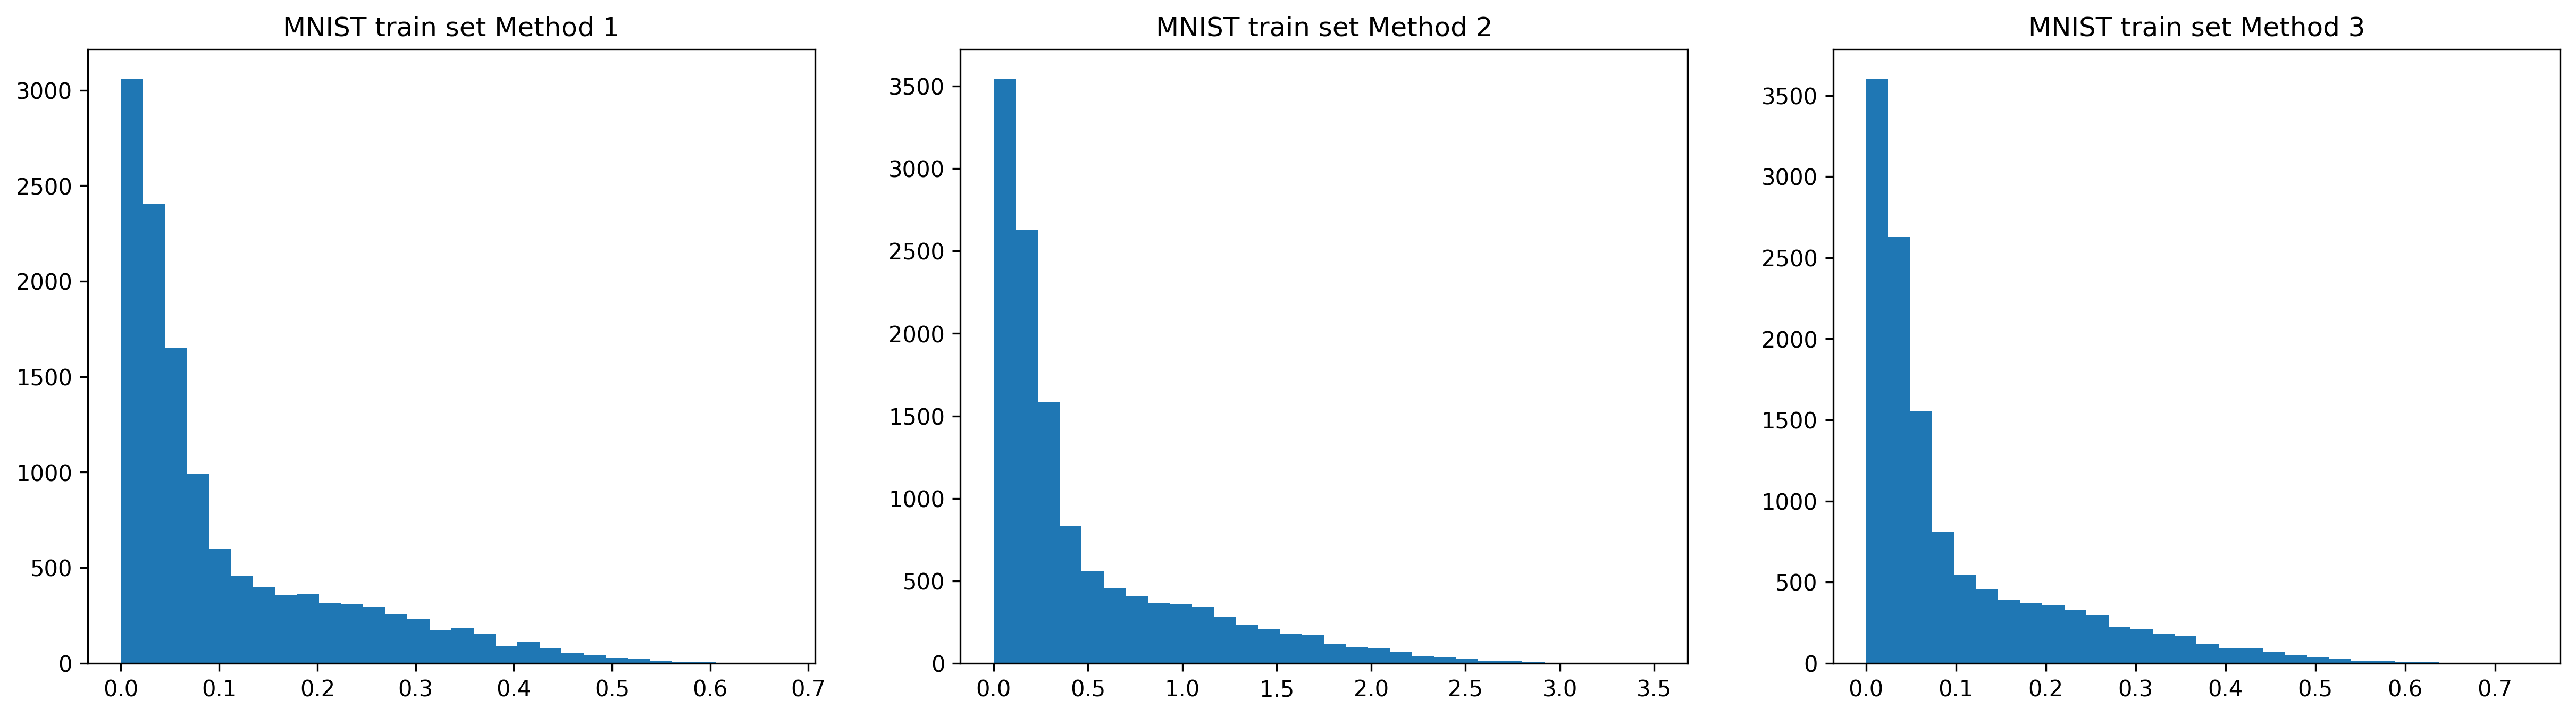

In [13]:
fig, axes = plt.subplots(1, 3, dpi=300, figsize=(20, 5))
axes[0].set_title('MNIST train set Method 1')
axes[0].hist(ep1s_train, bins=30)
axes[1].set_title('MNIST train set Method 2')
axes[1].hist(ep2s_train, bins=30)
axes[2].set_title('MNIST train set Method 3')
axes[2].hist(ep3s_train, bins=30)
fig.show()

/var/folders/0d/85ds7j1x59j1dwn1s6nph45m0000gn/T/ipykernel_24632/1386700517.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


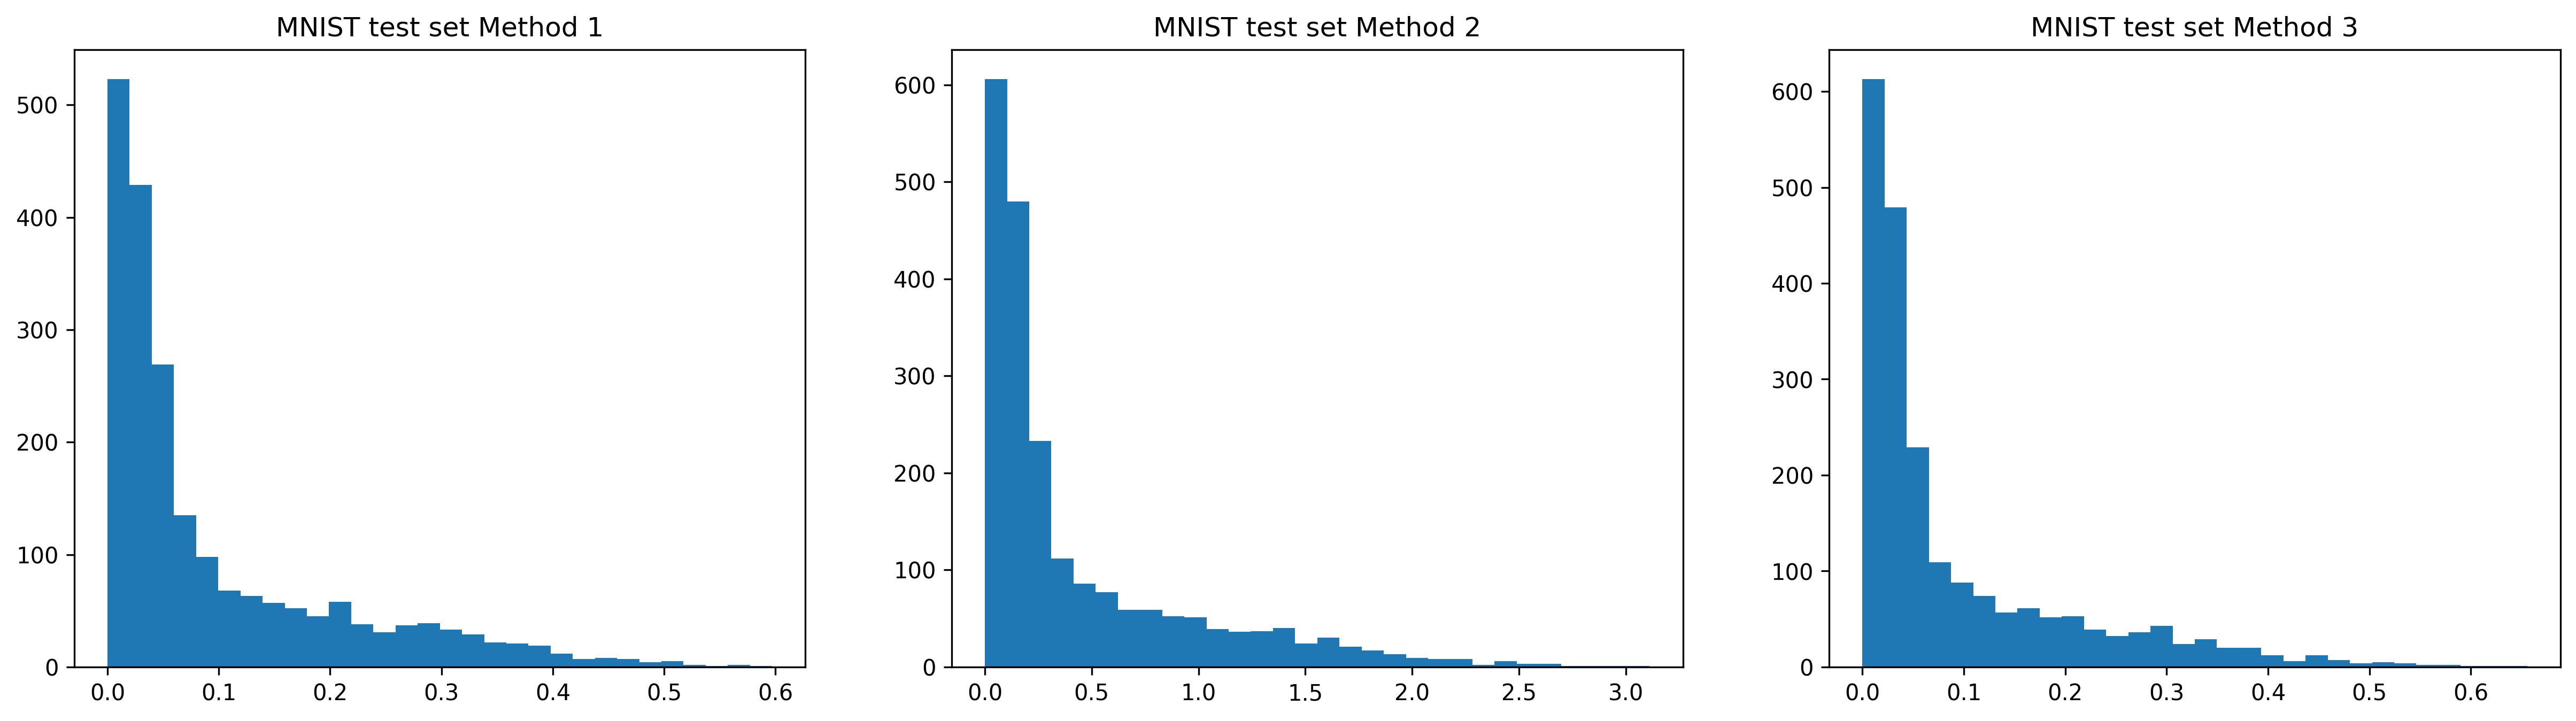

In [14]:
fig, axes = plt.subplots(1, 3, dpi=300, figsize=(20, 5))
axes[0].set_title('MNIST test set Method 1')
axes[0].hist(ep1s_test, bins=30)
axes[1].set_title('MNIST test set Method 2')
axes[1].hist(ep2s_test, bins=30)
axes[2].set_title('MNIST test set Method 3')
axes[2].hist(ep3s_test, bins=30)
fig.show()

In [15]:
train_accuracies = []
test_accuracies = []
noises = np.linspace(0, 1, 100)
for noise in noises:
    nvec = torch.empty_like(X_train[0]).normal_(0, 1)
    nvec *= noise / nvec.norm()

    preds = model.predict(X_train + nvec)
    train_acc = (preds == y_train).sum() / len(y_train)

    preds = model.predict(X_test + nvec)
    test_acc = (preds == y_test).sum() / len(y_test)

    print(nvec.norm(), train_acc, test_acc)

    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

tensor(0.) tensor(0.8425) tensor(0.7154)
tensor(0.0101) tensor(0.8426) tensor(0.7149)
tensor(0.0202) tensor(0.8429) tensor(0.7154)
tensor(0.0303) tensor(0.8434) tensor(0.7135)
tensor(0.0404) tensor(0.8426) tensor(0.7154)
tensor(0.0505) tensor(0.8436) tensor(0.7111)
tensor(0.0606) tensor(0.8429) tensor(0.7154)
tensor(0.0707) tensor(0.8429) tensor(0.7154)
tensor(0.0808) tensor(0.8427) tensor(0.7154)
tensor(0.0909) tensor(0.8437) tensor(0.7121)
tensor(0.1010) tensor(0.8412) tensor(0.7191)
tensor(0.1111) tensor(0.8421) tensor(0.7116)
tensor(0.1212) tensor(0.8431) tensor(0.7158)
tensor(0.1313) tensor(0.8418) tensor(0.7187)
tensor(0.1414) tensor(0.8413) tensor(0.7154)
tensor(0.1515) tensor(0.8420) tensor(0.7206)
tensor(0.1616) tensor(0.8418) tensor(0.7125)
tensor(0.1717) tensor(0.8388) tensor(0.7078)
tensor(0.1818) tensor(0.8428) tensor(0.7168)
tensor(0.1919) tensor(0.8396) tensor(0.7130)
tensor(0.2020) tensor(0.8415) tensor(0.7087)
tensor(0.2121) tensor(0.8415) tensor(0.7111)
tensor(0.2222)

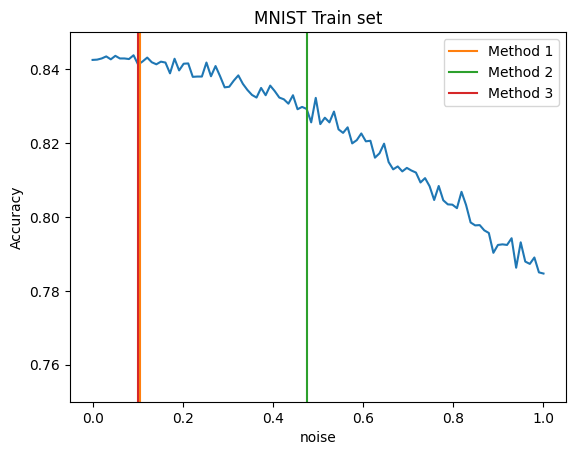

In [16]:
plt.figure(dpi=100)
plt.plot(noises, train_accuracies)
plt.plot([ep1s_train.mean(), ep1s_train.mean()], [0, 1], label='Method 1')
plt.plot([ep2s_train.mean(), ep2s_train.mean()], [0, 1], label='Method 2')
plt.plot([ep3s_train.mean(), ep3s_train.mean()], [0, 1], label='Method 3')
plt.legend()
plt.ylim([0.75, 0.85])
plt.title('MNIST Train set')
plt.xlabel('noise')
plt.ylabel('Accuracy')
plt.show()

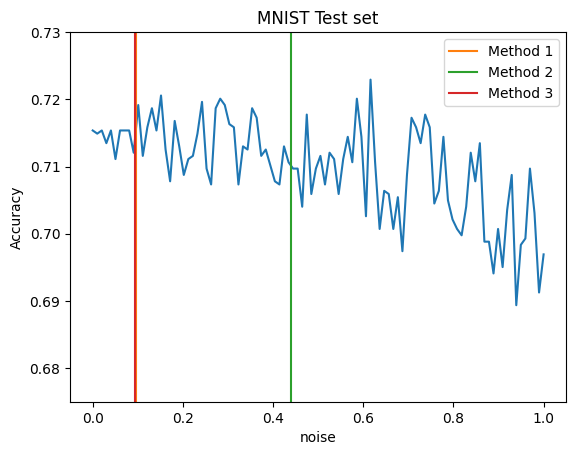

In [17]:
plt.figure(dpi=100)
plt.plot(noises, test_accuracies)
plt.plot([ep1s_test.mean(), ep1s_test.mean()], [0, 1], label='Method 1')
plt.plot([ep2s_test.mean(), ep2s_test.mean()], [0, 1], label='Method 2')
plt.plot([ep3s_test.mean(), ep3s_test.mean()], [0, 1], label='Method 3')
plt.legend()
plt.ylim([0.675, 0.73])
plt.title('MNIST Test set')
plt.xlabel('noise')
plt.ylabel('Accuracy')
plt.show()